<h1><center>🚸 GTSRB German Road Signs (Convolutional Neural Network) 🚸</center></h1>
<p><center><i>By Natan Szczepaniak</i></center></p>

<img width="400px" src="road_signs_header.jpeg"/>

# 1. 📝 Intro

For this assignment I decided to go for the ambitious task of using three different variations of Neural networks (2 CNN) for the classification of the German Road Signs dataset consisting of 43 different classes seen below.

<img width=400 src="https://production-media.paperswithcode.com/datasets/GTSRB-0000000633-9ce3c5f6_Dki5Rsf.jpg"/>

I decided to go for this to challenge myself and stretch my knowledge of Convolutional Neural Networks. In my past I have done 2 projects involving convolution: Turing Pattern Simulation and Canny edge detection.

The Turing Pattern simulation project focused on comparing different methods of making calculating convolutions quicker using two methods, brute force (multiplying the kernel via matrix multiplication) and preforming the convolution in fourier space improving the big-O notation from $O(N^2)$ to $O(N^2log^2N)$.

**The code and paper for this project can be** [found here](https://github.com/natan-sz/independent-reaction-diffusion)

Having also worked with neural networks in the past I thought it would be a good chance for me to try implement a convolutional neural network model to a dataset of coloured images. I will take a iterative approach to the models starting out with testing the data on a neural network with no convolution layers and slowly build up into more complex models.

To test out the models I created a quick utility to test the accuracy of the model on live data from the webcam.

In [1]:
# Uncomment if missing dependencies
# !pip3 install wget tensorflow numpy matplotlib Pillow pandas tqdm scitkit-learn seaborn

# 2. 📊 Download, Preprocess and put image data into numpy arrays

The code below downloads the dataset from the ERDA website (if not downloaded already) and loads it into a neat format in a numpy array.

Unfortunately the images are not of uniform shape which would make it difficult to train our model on as it would mean irregular input parameters, this means we need to resize the images to 30x30x3 dimensions. Usually I would do this once, save the dataset and load it in later but I did this verbosely for demonstration purposes.

The [source of the data](https://benchmark.ini.rub.de) provided a sample code to load in the data from their website however it was written in Python2 using outdated libraries so I redid it myself.

In [1]:
import os
import wget
import zipfile
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
from numpy.random import randint
from numpy.random import choice
import pandas as pd
from PIL import Image
from tqdm import tqdm
from tensorflow.math import confusion_matrix
from keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report
import seaborn as sns
import pickle
from tensorflow.keras.optimizers import Adam

# Custom packages for this project
from road_labels import label_name
from colours import colour

# check TF version
print("TensorFlow Version: " + tf.__version__)

TensorFlow Version: 2.8.0


In [2]:
### LOAD IN THE DATASET (276MB) ###

# Image Constants & Dimensions
IMG_WIDTH = 30
IMG_HEIGHT = 30
CHANNELS = 3
CLASSES = 43

# Location of data
CUR_DIR = os.getcwd()
URL = "https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Training_Images.zip"

In [3]:
# Function to load in data given a path
def load_roadsigns(path):
    # Initialise the output arrays
    X = [] # images
    y = np.array([]) # labels
    
    print("Resizing images...")
    # Iterate through all the directories, pull out images and resize
    for i in range(CLASSES):
        
        # Messing around with paths of where the data is found
        class_label = f"{i:05}"
        class_folder = path+f"/{class_label}"
        datasheet = pd.read_csv(class_folder+f"/GT-{class_label}.csv",delimiter=";")

        image_files = list(datasheet["Filename"])
        labels = list(datasheet["ClassId"])
        
        y = np.append(y,labels)
        
        # Open each image, resize and save into numpy array
        for image_file in tqdm(image_files):
            try: 
                image = Image.open(class_folder+"/"+image_file) 
                image = image.resize((IMG_WIDTH,IMG_HEIGHT)) 
                image = np.array(image)
                X.append(image)
            except: 
                print("Erorr loading in image")
                break
                
    # Converting to numpy arrays
    # It was actually quicker to do the appending in native lists and converting lol ¯\_(ツ)_/¯
    X = np.array(X)
    y = y.astype(int)
                
    return X, y

In [4]:
# Check if file already downloaded
if not os.path.isfile("GTSRB_Final_Training_Images.zip"):
    if not os.path.isdir("GTSRB"):
        print("Downloading Dataset...")
        wget.download(URL,".")
        print("Downloaded!")
        
        # Unzip the file into a folder
        with zipfile.ZipFile("GTSRB_Final_Training_Images.zip","r") as zip_ref:
            zip_ref.extractall(".")
        
        os.remove("GTSRB_Final_Training_Images.zip")
    else:
        print("Dataset already downloaded.")
else:
    print("Dataset already downloaded.")
    
# Load in dataset into memory
X, y = load_roadsigns("GTSRB/Final_Training/Images")
X = X/255

Dataset already downloaded.
Resizing images...


100%|███████████████████████████████████████| 240/240 [00:00<00:00, 1329.96it/s]


# 3. 🌎 Data Exploration
Now that the dataset is downloaded and reshaped to 30x30x3 dimensions we can look at what the images actually look like and the labels that are available to us.

I have created a seperate python module which holds the corresponding names for label numbers. This is in a form of a simple dictionary which can be referenced for ease of use and to reduce bloated code in this notebook.

In [5]:
print(f"Dimensions of images array: {X.shape}")
print(f"Dimensions of labels array: {y.shape}")

Dimensions of images array: (39209, 30, 30, 3)
Dimensions of labels array: (39209,)


We have around ~40k images to play around with making this a sizable dataset to split up for training, testing and validation. Before we do this though, lets explore the images some more.

In [6]:
maps = ["Reds","Greens","Blues"]

# Here we can visualise our images and their corresponding labels
def plot_sign(X,y,n):
    plt.imshow(X[n])
    plt.title(label_name[y[n]])

def plot_sign_rgb(X,y,n):
    fig, ax = plt.subplots(1,CHANNELS,figsize=(10,10))
    for i in range(CHANNELS):
        ax[i].imshow(X[n][:, :, i],cmap=maps[i])
        ax[i].title.set_text(str(maps[i]))
        
# Function to get sign by label number
def get_sign_by_label(label):
    return X[y.tolist().index(label)]
    

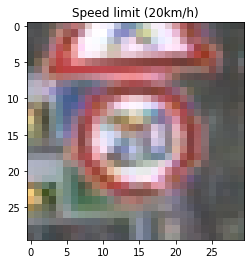

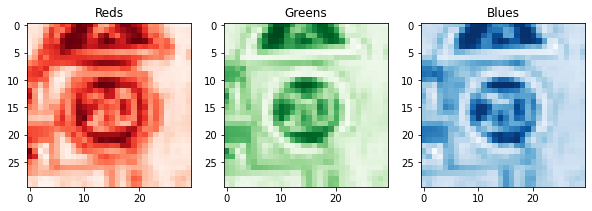

In [7]:
# Change index to see image and associated label
n = 0

# Plots actual image
plot_sign(X,y,n)
# Plots RGB decomposition, the darker the higher value
plot_sign_rgb(X,y,n)

Lets have a look at all of the classes available to us

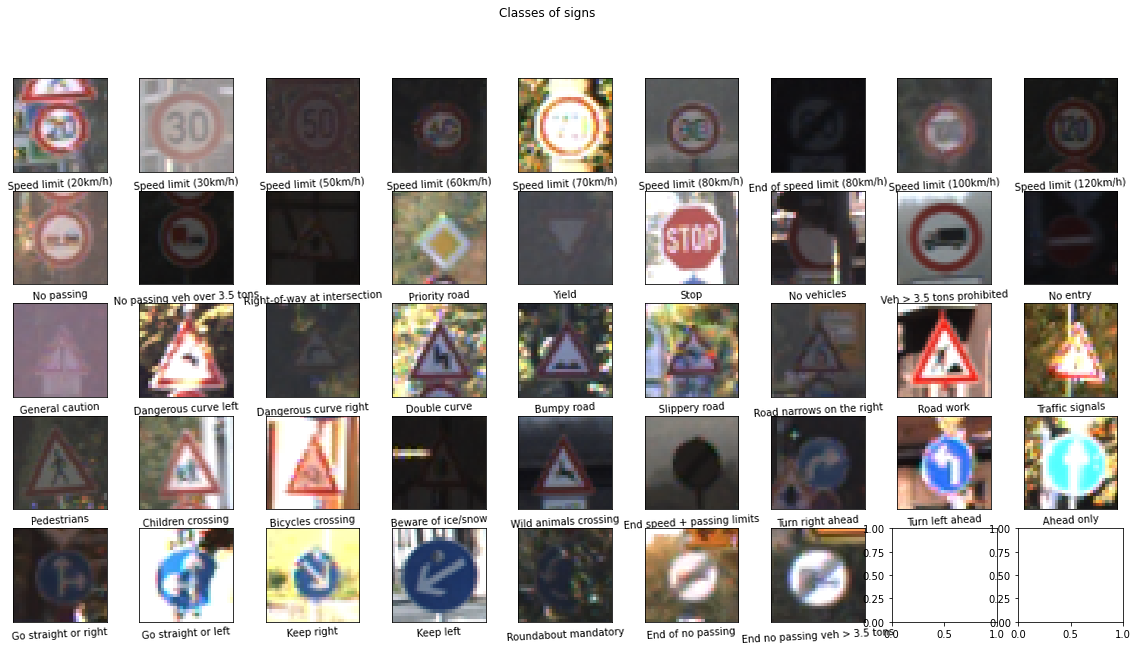

In [8]:
figdim = (5,9)

fig, ax = plt.subplots(figdim[0],figdim[1],figsize=(20,10))
fig.suptitle("Classes of signs")

label_count = 0

for i in range(figdim[0]):
    for j in range(figdim[1]):
        if label_count == 43:
            break
        ax[i][j].imshow(get_sign_by_label(label_count))
        ax[i][j].set_xlabel(label_name[label_count],rotation=3)
        ax[i][j].set_xticks([])
        ax[i][j].set_yticks([])
        label_count +=1

Great! some of these are darker than others, some look overexposed and some dont even look like anything (Roundabout Mandatory)

now lets take a look how these classes are distributed to see if we have a balanced dataset

<AxesSubplot:title={'center':'Class Distribution of Images'}, xlabel='label_name', ylabel='no. of images'>

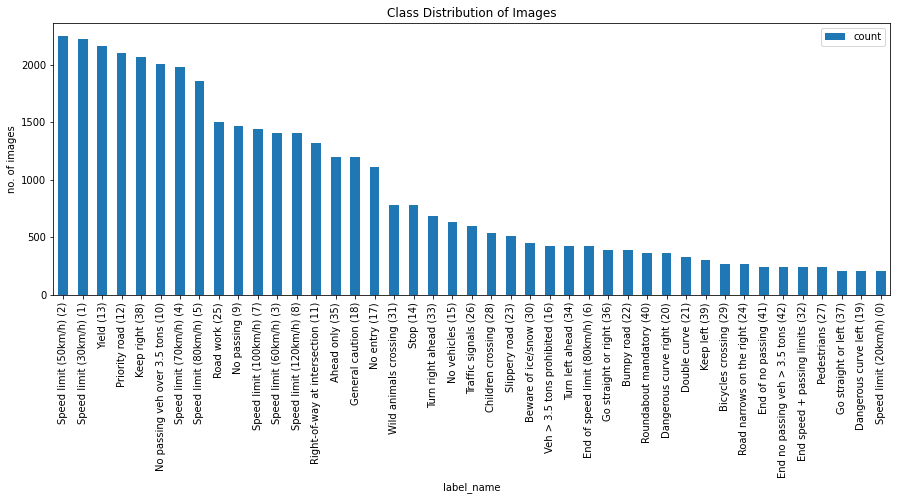

In [9]:
def format_label(label):
    return label_name[label]+f" ({label})"

# Plotting the distribution of the data
dist = pd.DataFrame({"label":np.unique(y),"count":np.bincount(y)})
dist["label_name"] = dist["label"].apply(format_label)
dist = dist.sort_values("count",ascending=False)

dist.plot(kind="bar",x="label_name",y="count",figsize=(15,5),title="Class Distribution of Images",ylabel="no. of images")

In [10]:
dist

,label,count,label_name
2,2,2250,Speed limit (50km/h) (2)
1,1,2220,Speed limit (30km/h) (1)
13,13,2160,Yield (13)
12,12,2100,Priority road (12)
38,38,2070,Keep right (38)
10,10,2010,No passing veh over 3.5 tons (10)
4,4,1980,Speed limit (70km/h) (4)
5,5,1860,Speed limit (80km/h) (5)
25,25,1500,Road work (25)
9,9,1470,No passing (9)


We can clearly see by this that this dataset is extremely skewed. There are 2250 images for the **Speed limit (50km/h)** and only 210 images for the **Speed limit (20km/h)** class.

This would make any model we make into being biased or perform better the classes with more training images. To address this we can create more data by rotating, transforming and resizing the images.

Before this however we need to split the data into Test/Train/Validation datasets.

# 4. 🖖 Splitting the Data

For training, testing and validation purposes, we must split the data into datasets that retain the ratios of images available.

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42, shuffle=True)

In [12]:
# See shape of the train and test datasets
print(f"Train dataset shape: {X_train.shape}")
print(f"Validation dataset shape: {X_val.shape}")
print(f"Test dataset shape: {X_test.shape}")

Train dataset shape: (28230, 30, 30, 3)
Validation dataset shape: (3137, 30, 30, 3)
Test dataset shape: (7842, 30, 30, 3)


In order to sanity check if the training and validation sets have enough images for the classes with the least samples.

In [13]:
# Plotting the distribution of the training data
train_dist = pd.DataFrame({"label":np.unique(y_train),"count":np.bincount(y_train)})
train_dist["label_name"] = train_dist["label"].apply(format_label)
train_dist = train_dist.sort_values("count",ascending=False)

# Plotting the distribution of the val data
val_dist = pd.DataFrame({"label":np.unique(y_val),"count":np.bincount(y_val)})
val_dist["label_name"] = val_dist["label"].apply(format_label)
val_dist = val_dist.sort_values("count",ascending=False)

print(colour.BOLD+"Training least samples:"+colour.END)
print(train_dist[-10:])
print(colour.BOLD+"\nValidation least samples:"+colour.END)
print(val_dist[-10:])

Training least samples:
    label  count                          label_name
39     39    220                      Keep left (39)
24     24    195      Road narrows on the right (24)
29     29    193              Bicycles crossing (29)
42     42    183  End no passing veh > 3.5 tons (42)
32     32    183     End speed + passing limits (32)
41     41    182              End of no passing (41)
27     27    180                    Pedestrians (27)
0       0    158            Speed limit (20km/h) (0)
37     37    154            Go straight or left (37)
19     19    154           Dangerous curve left (19)

Validation least samples:
    label  count                          label_name
39     39     22                      Keep left (39)
29     29     18              Bicycles crossing (29)
42     42     16  End no passing veh > 3.5 tons (42)
32     32     16     End speed + passing limits (32)
24     24     16      Road narrows on the right (24)
0       0     14            Speed limit (20km/h)

The lowest amount of samples in the training dataset is 154 which is low compared to the 2000 high but with data augmentation we can tackle this. The validation dataset only has 9 images for class 37 which is low but I can live with it.

# 5. 🤖 Data Augmentation

Biggest issue with this dataset is the skewedness of the images available for each class. If used for training, this would lead to some classes being predicted with higher accuracy than others. The model could also be skewed towards these samples.

To combat this we can generate some more data by rotating, shifting, shearing and zooming. For this example I have chosen a rotation of 10 degrees (as roadsigns wouldnt rotate that much irl, also any more would mess up arrow directions) and shift of 10% together with a "reflect" mode which fills in the area of the image with a reflecting image.

Doing this will prevent overfitting and allow the network to generalise better.

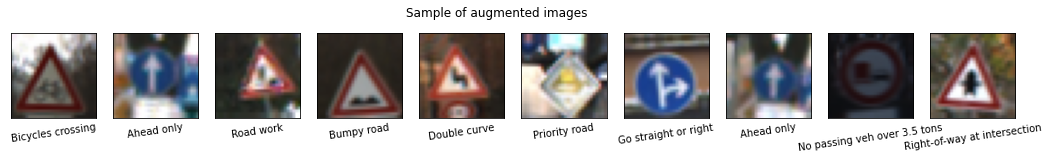

In [14]:
datagen = ImageDataGenerator(
    rotation_range=10, # Rotate randomly from 0 to 10 (not too far)
    height_shift_range=0.1,
    width_shift_range=0.1,
    horizontal_flip=False,
    fill_mode="reflect")

# Fits data to allow for augmentation with the flow method
datagen.fit(X_train)

# Visualise a sample of the augmented images
fig, ax = plt.subplots(1,10,figsize=(18,2))
fig.suptitle("Sample of augmented images")

# Visualise the transformations on the images. (seed set to prevent changing results.)
for X_batch, y_batch in datagen.flow(X_train, y_train,shuffle=False):    
    for i in range(0, 10):
        ax[i].imshow(X_batch[i])
        ax[i].set_xlabel(label_name[y_batch[i]],rotation=8)
        ax[i].set_xticks([])
        ax[i].set_yticks([])
    # break out of the loop before it goes on...
    break

I have chosen a AUG_COUNT of 1600 which is around the number of the class with most samples. This may be quite high seeing as the lowest classes only have ~200 meaning we are repeating the data a lot (even if augmented) which may be a problem later.

In [15]:
AUG_COUNT = 1600
BATCH_SIZE = 32

# I will save the augmented with equal amounts of
# image classes in numpy arrays
# Usually you wouldnt waste memory like this but I
# want to compare the accuracy of model with and without augmentation.
X_train_aug = []
y_train_aug = []

# Iterate over each class and 
# generate AUG_COUNT augmented images
for class_ in range(CLASSES):
    print(f"{class_+1}/{CLASSES} Generating data for class: {label_name[class_]}")
    indices = [i for i, x in enumerate(y_train) if x == class_]  # Get indexes of all instances of that class
    
    for i in tqdm(range(AUG_COUNT)):
        img_to_transform = X_train[choice(indices)]
        transformed_img = datagen.random_transform(img_to_transform)
        
        X_train_aug.append(transformed_img)
        y_train_aug.append(class_)

X_train_aug = np.array(X_train_aug)
y_train_aug = np.array(y_train_aug)

# THIS IS AN ALTERNATIVE METHOD HOWEVER IT PERFORMED BADLY    

# This for loop should create a balanced dataset (inefficient af but fix for another time)
# for X_batch, y_batch in datagen.flow(X_train, y_train,seed=42,batch_size=BATCH_SIZE):
#     for i in range(BATCH_SIZE):
#         class_count = train_dist_sorted.at[y_batch[i],"aug_count"]
#         if class_count != AUG_COUNT:
#             X_train_aug.append(X_batch[i])
#             y_train_aug.append(y_batch[i])
#             train_dist_sorted.at[y_batch[i],"aug_count"] = class_count + 1
#         else:
#             print(f"Class: {label_name[y_batch[i]]} is filled to {AUG_COUNT}!")

1/43 Generating data for class: Speed limit (20km/h)


100%|█████████████████████████████████████| 1600/1600 [00:01<00:00, 1391.74it/s]


2/43 Generating data for class: Speed limit (30km/h)


100%|█████████████████████████████████████| 1600/1600 [00:00<00:00, 1672.62it/s]


3/43 Generating data for class: Speed limit (50km/h)


100%|█████████████████████████████████████| 1600/1600 [00:00<00:00, 1686.50it/s]


4/43 Generating data for class: Speed limit (60km/h)


100%|█████████████████████████████████████| 1600/1600 [00:00<00:00, 1820.89it/s]


5/43 Generating data for class: Speed limit (70km/h)


100%|█████████████████████████████████████| 1600/1600 [00:01<00:00, 1587.98it/s]


6/43 Generating data for class: Speed limit (80km/h)


100%|█████████████████████████████████████| 1600/1600 [00:00<00:00, 1693.28it/s]


7/43 Generating data for class: End of speed limit (80km/h)


100%|█████████████████████████████████████| 1600/1600 [00:00<00:00, 1970.33it/s]


8/43 Generating data for class: Speed limit (100km/h)


100%|█████████████████████████████████████| 1600/1600 [00:00<00:00, 1875.49it/s]


9/43 Generating data for class: Speed limit (120km/h)


100%|█████████████████████████████████████| 1600/1600 [00:00<00:00, 1854.74it/s]


10/43 Generating data for class: No passing


100%|█████████████████████████████████████| 1600/1600 [00:00<00:00, 1873.28it/s]


11/43 Generating data for class: No passing veh over 3.5 tons


100%|█████████████████████████████████████| 1600/1600 [00:01<00:00, 1506.95it/s]


12/43 Generating data for class: Right-of-way at intersection


100%|█████████████████████████████████████| 1600/1600 [00:00<00:00, 1767.05it/s]


13/43 Generating data for class: Priority road


100%|█████████████████████████████████████| 1600/1600 [00:00<00:00, 1864.79it/s]


14/43 Generating data for class: Yield


100%|█████████████████████████████████████| 1600/1600 [00:00<00:00, 1808.93it/s]


15/43 Generating data for class: Stop


100%|█████████████████████████████████████| 1600/1600 [00:00<00:00, 1970.64it/s]


16/43 Generating data for class: No vehicles


100%|█████████████████████████████████████| 1600/1600 [00:00<00:00, 1782.94it/s]


17/43 Generating data for class: Veh > 3.5 tons prohibited


100%|█████████████████████████████████████| 1600/1600 [00:00<00:00, 2023.75it/s]


18/43 Generating data for class: No entry


100%|█████████████████████████████████████| 1600/1600 [00:00<00:00, 1938.14it/s]


19/43 Generating data for class: General caution


100%|█████████████████████████████████████| 1600/1600 [00:00<00:00, 1933.21it/s]


20/43 Generating data for class: Dangerous curve left


100%|█████████████████████████████████████| 1600/1600 [00:00<00:00, 2153.55it/s]


21/43 Generating data for class: Dangerous curve right


100%|█████████████████████████████████████| 1600/1600 [00:00<00:00, 2162.05it/s]


22/43 Generating data for class: Double curve


100%|█████████████████████████████████████| 1600/1600 [00:00<00:00, 2210.42it/s]


23/43 Generating data for class: Bumpy road


100%|█████████████████████████████████████| 1600/1600 [00:00<00:00, 1905.99it/s]


24/43 Generating data for class: Slippery road


100%|█████████████████████████████████████| 1600/1600 [00:00<00:00, 1906.41it/s]


25/43 Generating data for class: Road narrows on the right


100%|█████████████████████████████████████| 1600/1600 [00:00<00:00, 2224.12it/s]


26/43 Generating data for class: Road work


100%|█████████████████████████████████████| 1600/1600 [00:00<00:00, 1801.08it/s]


27/43 Generating data for class: Traffic signals


100%|█████████████████████████████████████| 1600/1600 [00:00<00:00, 1891.47it/s]


28/43 Generating data for class: Pedestrians


100%|█████████████████████████████████████| 1600/1600 [00:00<00:00, 1799.19it/s]


29/43 Generating data for class: Children crossing


100%|█████████████████████████████████████| 1600/1600 [00:00<00:00, 2102.26it/s]


30/43 Generating data for class: Bicycles crossing


100%|█████████████████████████████████████| 1600/1600 [00:00<00:00, 1929.50it/s]


31/43 Generating data for class: Beware of ice/snow


100%|█████████████████████████████████████| 1600/1600 [00:00<00:00, 2139.01it/s]


32/43 Generating data for class: Wild animals crossing


100%|█████████████████████████████████████| 1600/1600 [00:00<00:00, 1873.31it/s]


33/43 Generating data for class: End speed + passing limits


100%|█████████████████████████████████████| 1600/1600 [00:00<00:00, 1728.87it/s]


34/43 Generating data for class: Turn right ahead


100%|█████████████████████████████████████| 1600/1600 [00:00<00:00, 1663.55it/s]


35/43 Generating data for class: Turn left ahead


100%|█████████████████████████████████████| 1600/1600 [00:00<00:00, 1763.51it/s]


36/43 Generating data for class: Ahead only


100%|█████████████████████████████████████| 1600/1600 [00:00<00:00, 1817.99it/s]


37/43 Generating data for class: Go straight or right


100%|█████████████████████████████████████| 1600/1600 [00:00<00:00, 1908.24it/s]


38/43 Generating data for class: Go straight or left


100%|█████████████████████████████████████| 1600/1600 [00:00<00:00, 1972.87it/s]


39/43 Generating data for class: Keep right


100%|█████████████████████████████████████| 1600/1600 [00:00<00:00, 1760.02it/s]


40/43 Generating data for class: Keep left


100%|█████████████████████████████████████| 1600/1600 [00:01<00:00, 1312.03it/s]


41/43 Generating data for class: Roundabout mandatory


100%|█████████████████████████████████████| 1600/1600 [00:01<00:00, 1413.06it/s]


42/43 Generating data for class: End of no passing


100%|█████████████████████████████████████| 1600/1600 [00:00<00:00, 1810.57it/s]


43/43 Generating data for class: End no passing veh > 3.5 tons


100%|█████████████████████████████████████| 1600/1600 [00:00<00:00, 1917.95it/s]


In [16]:
# Get the class distribution of the train augmented dataset
train_aug_dist = pd.DataFrame({"label":np.unique(y_train_aug),"count":np.bincount(y_train_aug)})
train_aug_dist["label_name"] = train_aug_dist["label"].apply(format_label)
train_aug_dist = train_aug_dist.sort_values("count",ascending=False)

train_aug_dist.head()

,label,count,label_name
0,0,1600,Speed limit (20km/h) (0)
32,32,1600,End speed + passing limits (32)
24,24,1600,Road narrows on the right (24)
25,25,1600,Road work (25)
26,26,1600,Traffic signals (26)


Shape of the Augmented X: (68800, 30, 30, 3)
Shape of the Augmented y: (68800,)


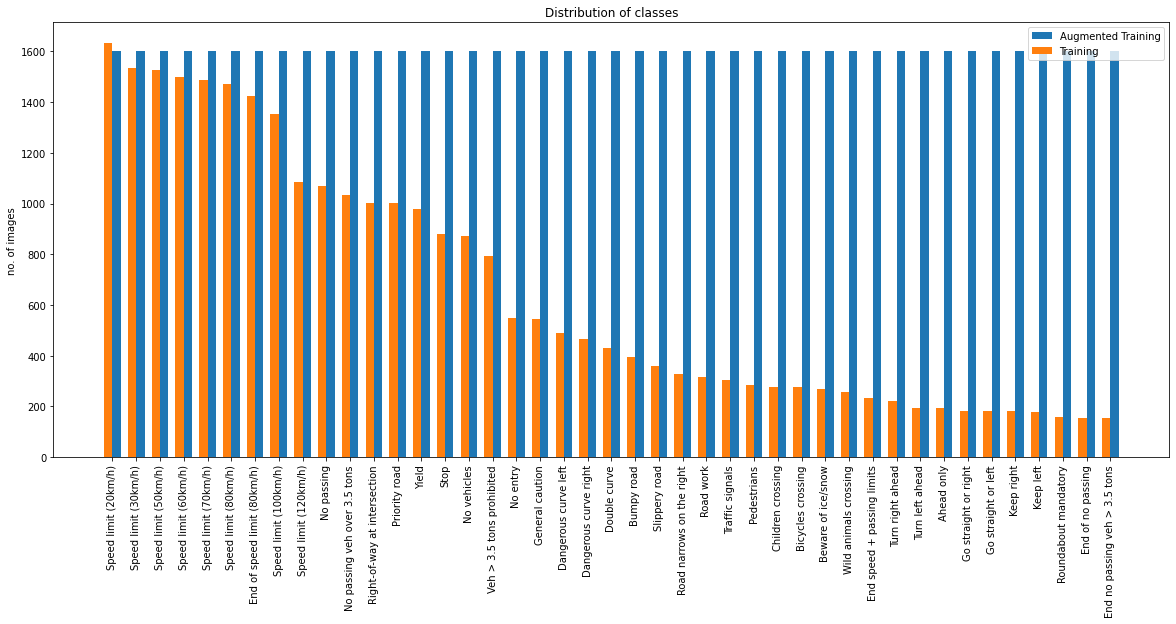

In [17]:
# Plot Training vs Augmented Training Datsets
#
# train_dist - before augmentation
# train_aug_dist - after augmentation
#

x = np.arange(len(train_dist["label"])) # the label locations
labels = list(label_name.values())
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(20,8))

train_aug = ax.bar(x + width/2, train_aug_dist["count"], width, label='Augmented Training')
train = ax.bar(x - width/2, train_dist["count"], width, label='Training')

ax.set_xticks(x,labels,rotation=90)
ax.set_ylabel('no. of images')
ax.set_title('Distribution of classes')

ax.legend()
print(f"Shape of the Augmented X: {X_train_aug.shape}")
print(f"Shape of the Augmented y: {y_train_aug.shape}")

Here FINALLY we can see that all of the classes have the same amount of images. Our data is ready for our model!!!!

#### To recap, our data is:
1. Downloaded
2. Resized to 30x30x3
3. Split to Test,Train,Validate
4. Train dataset has been augmented to equalise classes


# 5. 🏗️ Model Construction 

To test out how effective our CNN model is, we will test out 3 different architecutres.

- **Model Alpha** - No convolution layer. (2 hidden layers)
- **Model Beta** - Altered LeNet-5 with alterations.
- **Model Gamma** - 4 Convolution Layers, then a huge 512 dense network. (NN from Kaggle promising 98% accuracy for this dataset)

I expect model alpha to not generalise as well as it does not pick up on the location of the features.  Additionally it would be extremely computationally expensive due to the sheer number of computation it has an input of (width * height * rgb). In convolutional neural networks the number of trainable parameters should be less and be able to get better accuracy.

Finally I expect model gamma to perform best however it may be a bit too complex for the data and overfit.

## 5.1 α Model Alpha (No convolution layer)

This is just a test to see how a model with no convolutional layers to see how it perfoms against models with feature extraction. This model should be too simplistic to pick up on features of the signs and will end up remembering where the correct pixels are. With quite similar pictures and the access to RGB channels this would be an ok tactic but it would fall apart when signs are more displaced.

In [21]:
model_alpha = keras.Sequential([
    # Neural Network
    keras.layers.Flatten(input_shape=(IMG_HEIGHT,IMG_WIDTH,CHANNELS)),
    keras.layers.Dense(1000,activation='relu'),
    keras.layers.Dense(500,activation='relu'),
    
    # Output
    keras.layers.Dense(43,activation = 'softmax')
])
model_alpha.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 2700)              0         
                                                                 
 dense_3 (Dense)             (None, 1000)              2701000   
                                                                 
 dense_4 (Dense)             (None, 500)               500500    
                                                                 
 dense_5 (Dense)             (None, 43)                21543     
                                                                 
Total params: 3,223,043
Trainable params: 3,223,043
Non-trainable params: 0
_________________________________________________________________


For training the model we will use the sparse_categorical_crossentropy loss function as our truth labels are values such as 0,1,2,3.. and are not one-hot encoded. Cross entropy is the go to loss function for neural networks.

For the optimiser I decided to go for adam rather than SGD as that is what I am the most used to and have used the most in the past.

In [22]:
model_alpha.compile(loss='sparse_categorical_crossentropy', optimizer="adam", metrics=['accuracy'])

Now we will train this model with a default batch size of 36 for 10 epochs

I made this cell rerunable so if the model is already trained and saved as a pickle file it will not retrain unless you delete the pickle file. This is for demo purposes to make it easier to run this notebook.

In [23]:
epochs = 10

if not os.path.isfile("alpha_history.npy") or not os.path.isfile("model_alpha_aug.pickle"):
    alpha_history = model_alpha.fit(X_train_aug, y_train_aug, batch_size=32, epochs=epochs,validation_data=(X_val, y_val))
    alpha_history = alpha_history.history
    np.save('alpha_history.npy',alpha_history)
    with open('model_alpha_aug.pickle', 'wb') as f:
        pickle.dump(model_alpha, f)
else:
    alpha_history = np.load('alpha_history.npy',allow_pickle='TRUE').item()
    with open('model_alpha_aug.pickle', 'rb') as f:
        model_alpha = pickle.load(f)


Epoch 1/10
883/883 [==============================] - 14s 15ms/step - loss: 1.6962 - accuracy: 0.5427 - val_loss: 0.9487 - val_accuracy: 0.7023
Epoch 2/10
883/883 [==============================] - 13s 14ms/step - loss: 0.6887 - accuracy: 0.8049 - val_loss: 1.0467 - val_accuracy: 0.7220
Epoch 3/10
883/883 [==============================] - 15s 17ms/step - loss: 0.5088 - accuracy: 0.8550 - val_loss: 0.3880 - val_accuracy: 0.8830
Epoch 4/10
883/883 [==============================] - 12s 14ms/step - loss: 0.3889 - accuracy: 0.8871 - val_loss: 0.6846 - val_accuracy: 0.8100
Epoch 5/10
883/883 [==============================] - 13s 14ms/step - loss: 0.3285 - accuracy: 0.9035 - val_loss: 0.3451 - val_accuracy: 0.8954
Epoch 6/10
883/883 [==============================] - 12s 14ms/step - loss: 0.2857 - accuracy: 0.9160 - val_loss: 0.3263 - val_accuracy: 0.8980
Epoch 7/10
883/883 [==============================] - 12s 14ms/step - loss: 0.2518 - accuracy: 0.9254 - val_loss: 0.2626 - val_accuracy:

2022-04-09 12:03:09.777215: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ram://26a10522-dae1-41a7-bb91-e9ace9a3395e/assets


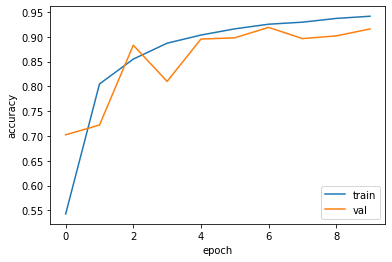

In [24]:
#alpha_history.history
plt.plot(alpha_history['accuracy'])
plt.plot(alpha_history['val_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower right')
plt.show()

In [25]:
model_alpha.evaluate(X_test,y_test)
#tf.keras.backend.clear_session()

246/246 [==============================] - 1s 5ms/step - loss: 0.3063 - accuracy: 0.9192


[0.30632877349853516, 0.9191532731056213]

In [26]:
probabilities_alpha = model_alpha.predict(X_test)
predictions_alpha = np.argmax(probabilities_alpha,axis=1)

In [27]:
# List of indexes that model got wrong
wrong_indices_alpha = [i for i,v in enumerate(predictions_alpha) if predictions_alpha[i]!=y_test[i]]
wrong_indices_alpha[:10]

[7, 34, 40, 61, 67, 69, 93, 100, 101, 111]

Model Predicted: Traffic signals
Confidence: 0.9934991598129272


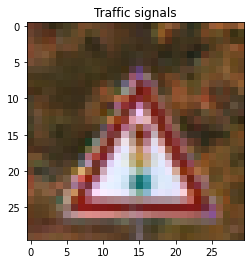

In [28]:
# Pick a number
n = 0

# Plot and check if prediction matches
plot_sign(X_test,y_test,n)
print(colour.BOLD+f"Model Predicted: {label_name[predictions_alpha[n]]}"+colour.END)
print(colour.BOLD+f"Confidence: {probabilities_alpha[n][predictions_alpha[n]]}"+colour.END)

Text(0.5, 114.0, 'Precited Labels')

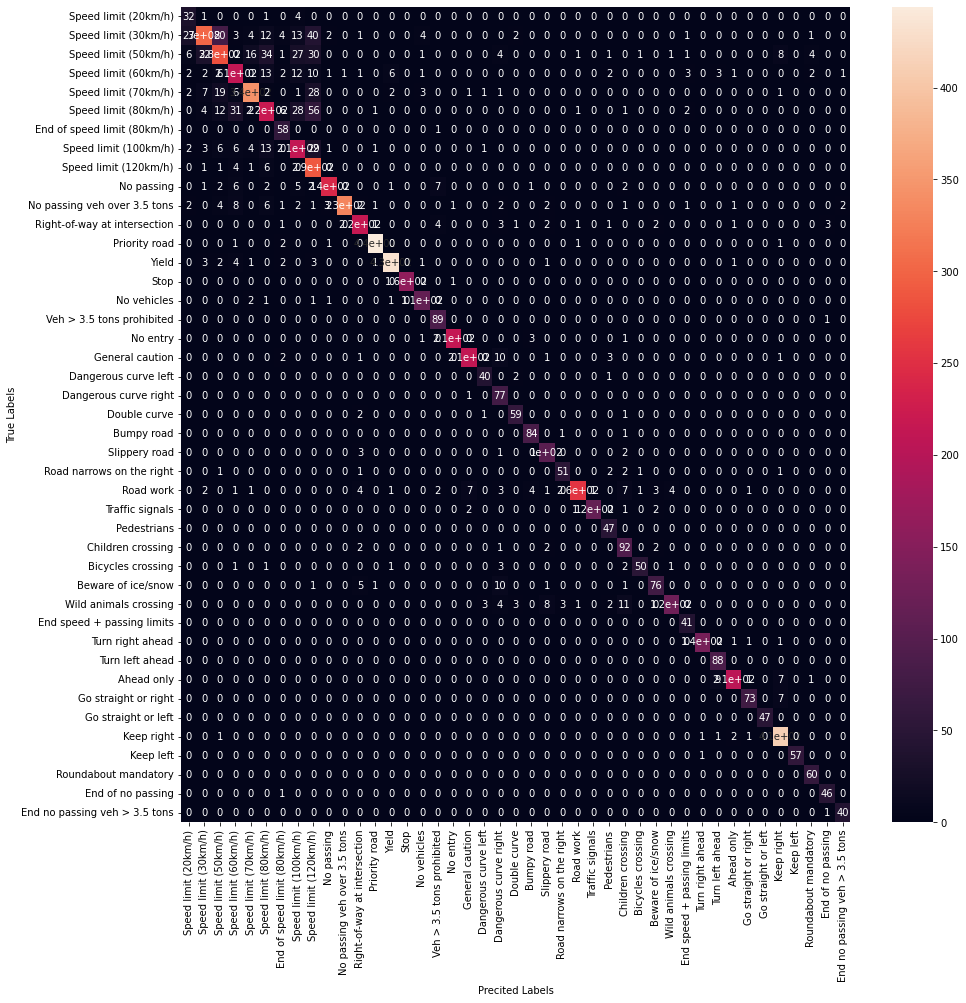

In [64]:
cm_mat = np.array(confusion_matrix(y_test,predictions_alpha))
cm_df = pd.DataFrame(cm_mat, index = [i for i in labels],
                  columns = [i for i in labels])
plt.figure(figsize = (15,15))
ax = sns.heatmap(cm_df, annot=True)
ax.set_ylabel("True Labels")
ax.set_xlabel("Precited Labels")

Because the confusion matrix is vv big and confusing (badum tsss) i decided to plot some of the main classes that were confused for other ones and how many times they were confused. This helps us empathise with the model and see why it thinks what it does.

array([[1, 2, 80],
       [5, 8, 56],
       [1, 8, 40],
       [2, 5, 34],
       [2, 1, 32]], dtype=object)

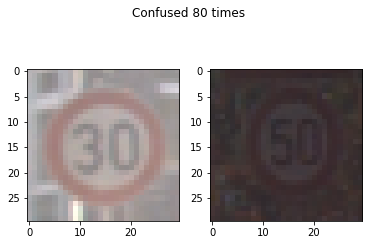

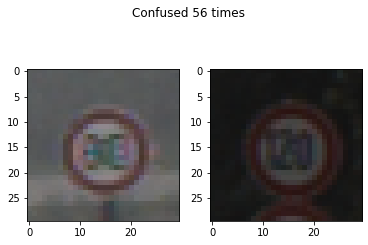

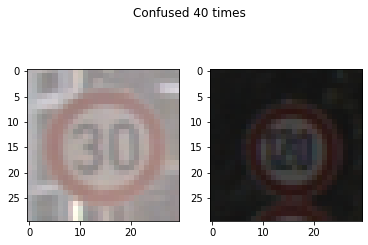

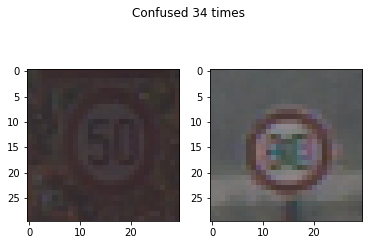

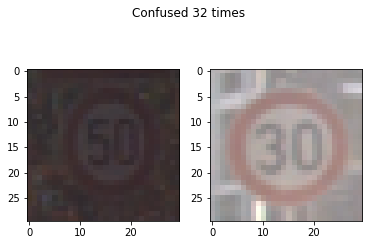

In [28]:
# Function to get coords of the most confused sign
# returns the predicted and actual labels sorted by the times they were confused
def most_confused_signs(conf_mat,number):
    # Create empty 0x3 array
    # true , predicted , number confused
    most_confused = np.empty((0,3),dtype=tuple)
    
    # Iterate through matrix to find most confused values
    for i in range(len(conf_mat)):
        for j in range(len(conf_mat[i])):
            if i != j and conf_mat[i][j] != 0:
                most_confused = np.vstack((most_confused,tuple((int(i),int(j),int(conf_mat[i][j]))))) 
    
    # Sort the numpy array and reverse it to get the most confused types.
    most_confused = most_confused[most_confused[:,2].argsort()][::-1]
    
    # Plot the images side by side
    for i in range(number):  
        fig, ax = plt.subplots(1,2)
        ax[0].imshow(get_sign_by_label(most_confused[i,0]))
        ax[0].set
        ax[1].imshow(get_sign_by_label(most_confused[i,1]))
        fig.suptitle(f"Confused {most_confused[i,2]} times")

    return most_confused[:number]

most_confused_signs(cm_mat,5)

To test out a datapoint from outside the dataset I went on google maps street view and found a sign I could use for this purpose. I found a no entry sign near my house to test out.

Model Predicted: No entry


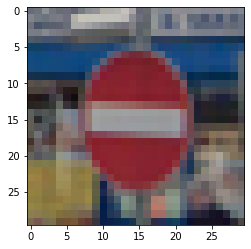

In [29]:
no_entry = Image.open('no_entry.png') 
no_entry = no_entry.resize((IMG_WIDTH,IMG_HEIGHT)) 
no_entry = np.array(no_entry)[:,:,:3]

plt.imshow(no_entry)

predictions = model_alpha.predict(np.array([no_entry]))
predictions = np.argmax(predictions,axis=1)

print("Model Predicted: " +label_name[int(predictions)])

It predicted it well, lets try adding convolutional layers and see if our accuracy improves.

## 5.2 β Model Beta (Simple CNN)

This model introduces some convolution and average pooling layers.

#### Convolution
The Conv2d Layers perform a convolution which is multiplying the entire matrix by a kernel of nxn size as shown below.
<img width=350 src="https://www.researchgate.net/profile/Chaim-Baskin/publication/318849314/figure/fig1/AS:614287726870532@1523469015098/Image-convolution-with-an-input-image-of-size-7-7-and-a-filter-kernel-of-size-3-3.png"/>

#### Average Pooling
Average pooling makes it so that we have less inputs by taking the output of the convolution and averaging out every other pixel. This essentially smooths the features out.
<img width=300 src="https://media.geeksforgeeks.org/wp-content/uploads/20190721025744/Screenshot-2019-07-21-at-2.57.13-AM.png"/>


I will use the exact same loss, optimiser and metrics as before for now. Because its an old network architecture it ues tanh. It would be worth experimenting changing this to relu or sigmoid.

In [29]:
model_beta = keras.models.Sequential([
    
    # Convolution
    keras.layers.Conv2D(filters=6, kernel_size=5, activation='tanh', input_shape=(IMG_HEIGHT,IMG_WIDTH,CHANNELS), padding='same'),
    keras.layers.AveragePooling2D(),
    
    # Convolution
    keras.layers.Conv2D(filters=16, kernel_size=5, activation='tanh', padding='valid'),
    keras.layers.AveragePooling2D(),
    
    # Convolution
    keras.layers.Conv2D(filters=120, kernel_size=5, activation='tanh', padding='valid'),
    
    
    keras.layers.Flatten(),
    keras.layers.Dense(84, activation='tanh'),
    keras.layers.Dense(43, activation='softmax')
])

model_beta.compile(loss='sparse_categorical_crossentropy', optimizer="adam", metrics=['accuracy'])

In [30]:
model_beta.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 6)         456       
                                                                 
 average_pooling2d (AverageP  (None, 15, 15, 6)        0         
 ooling2D)                                                       
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 16)        2416      
                                                                 
 average_pooling2d_1 (Averag  (None, 5, 5, 16)         0         
 ePooling2D)                                                     
                                                                 
 conv2d_2 (Conv2D)           (None, 1, 1, 120)         48120     
                                                                 
 flatten_2 (Flatten)         (None, 120)              

For training I will keep a number of epochs to 10 to keep it fair. I have also added Early stopping, at patience=3 it is not very useful as it will most likely not be reached but it comes from previous experimentation.

In [31]:
epochs = 10

es = EarlyStopping(monitor='val_loss', mode='min', patience=3)

if not os.path.isfile("beta_history_not_aug.npy") or not os.path.isfile("model_beta.pickle"):
    beta_history = model_beta.fit(X_train, y_train, batch_size=32, epochs=epochs,validation_data=(X_val, y_val),callbacks=[es])
    beta_history = beta_history.history
    np.save('beta_history_not_aug.npy',beta_history)
    with open('model_beta.pickle', 'wb') as f:
        pickle.dump(model_beta, f)
else:
    beta_history = np.load('beta_history_not_aug.npy',allow_pickle='TRUE').item()
    with open('model_beta.pickle', 'rb') as f:
        model_beta = pickle.load(f)

Epoch 1/10
883/883 [==============================] - 24s 26ms/step - loss: 1.0608 - accuracy: 0.7212 - val_loss: 0.3533 - val_accuracy: 0.9063
Epoch 2/10
883/883 [==============================] - 20s 22ms/step - loss: 0.2632 - accuracy: 0.9340 - val_loss: 0.1879 - val_accuracy: 0.9496
Epoch 3/10
883/883 [==============================] - 23s 26ms/step - loss: 0.1446 - accuracy: 0.9655 - val_loss: 0.1338 - val_accuracy: 0.9649
Epoch 4/10
883/883 [==============================] - 22s 25ms/step - loss: 0.0894 - accuracy: 0.9794 - val_loss: 0.1193 - val_accuracy: 0.9672
Epoch 5/10
883/883 [==============================] - 25s 28ms/step - loss: 0.0632 - accuracy: 0.9848 - val_loss: 0.0891 - val_accuracy: 0.9764
Epoch 6/10
883/883 [==============================] - 25s 28ms/step - loss: 0.0446 - accuracy: 0.9902 - val_loss: 0.0818 - val_accuracy: 0.9774
Epoch 7/10
883/883 [==============================] - 30s 33ms/step - loss: 0.0329 - accuracy: 0.9922 - val_loss: 0.0699 - val_accuracy:

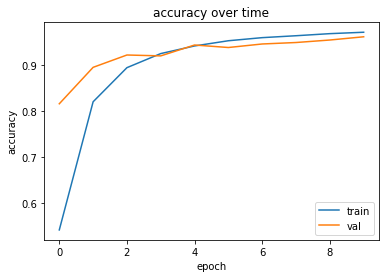

In [33]:
#alpha_history.history
# Loss
plt.plot(beta_history['accuracy'])
plt.plot(beta_history['val_accuracy'])
plt.title("accuracy over time")
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower right')
plt.show()

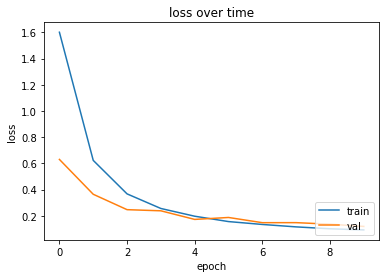

In [34]:
#alpha_history.history
plt.plot(beta_history['loss'])
plt.plot(beta_history['val_loss'])
plt.title("loss over time")
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower right')
plt.show()

The model learned really quickly (10 iterations) steep gradient. This may be due to the optimiser or the dataset being very similar to eachother.

In [66]:
model_beta.evaluate(X_test,y_test)

246/246 [==============================] - 2s 10ms/step - loss: 0.1420 - accuracy: 0.9582


[0.14203159511089325, 0.958173930644989]

In [36]:
probabilities_beta = model_beta.predict(X_test)
predictions_beta = np.argmax(probabilities_beta,axis=1)

# List of indexes that model got wrong
Feel free to change n and mess around to see what the model got wrong.

In [68]:
wrong_indices = [i for i,v in enumerate(predictions_beta) if predictions_beta[i]!=y_test[i]]
wrong_indices[:10]

[7, 26, 49, 90, 112, 117, 146, 166, 191, 197]

Model Predicted: Speed limit (60km/h)
Confidence: 0.5307875275611877


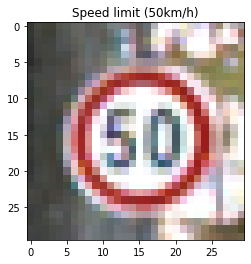

In [69]:
# Pick a number
n = 7

# Plot and check if prediction matches
plot_sign(X_test,y_test,n)
print(colour.BOLD+f"Model Predicted: {label_name[predictions_beta[n]]}"+colour.END)
print(colour.BOLD+f"Confidence: {probabilities_beta[n][predictions_beta[n]]}"+colour.END)

Text(0.5, 114.0, 'Precited Labels')

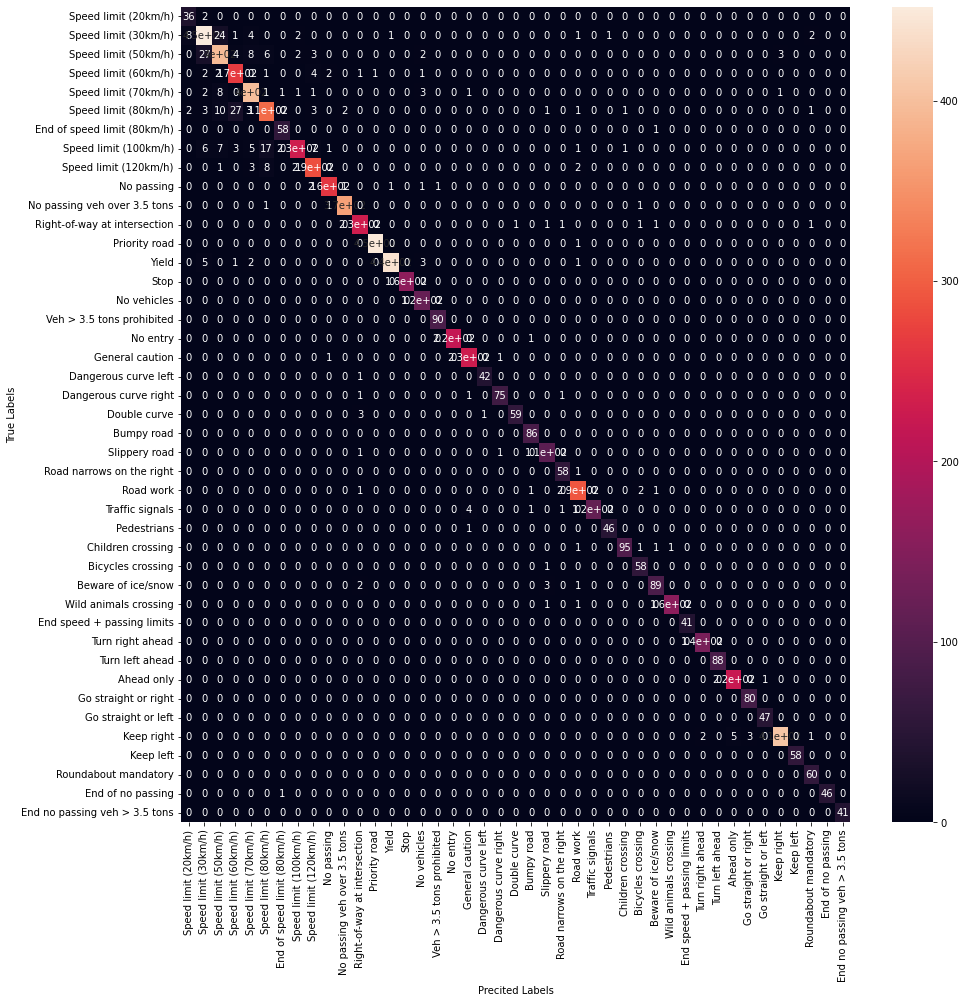

In [71]:
cm_mat_beta = np.array(confusion_matrix(y_test,predictions_beta))
cm_df = pd.DataFrame(cm_mat_beta, index = [i for i in labels],
                  columns = [i for i in labels])
plt.figure(figsize = (15,15))
ax = sns.heatmap(cm_df, annot=True)
ax.set_ylabel("True Labels")
ax.set_xlabel("Precited Labels")

We can clearly see that this model doesnt have as many misses however it still struggles with differences between speed limit signs.

array([[5, 3, 27],
       [2, 1, 27],
       [1, 2, 24],
       [7, 5, 17],
       [5, 2, 10]], dtype=object)

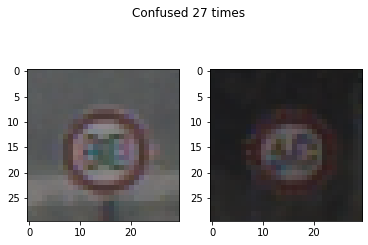

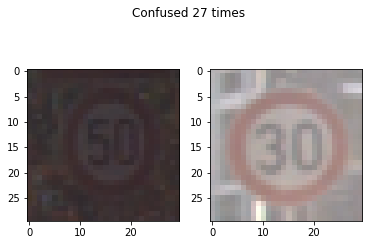

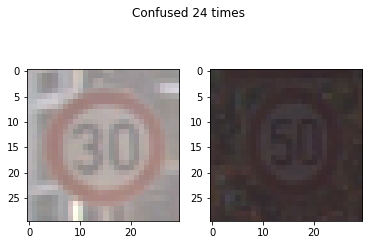

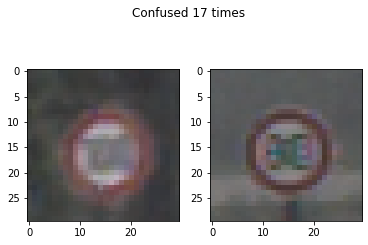

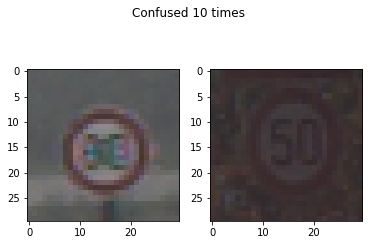

In [40]:
most_confused_signs(cm_mat_beta,5)

This is better, accuracy has improved from ~86% to ~95% by adding the convolution layers. The model still confuses the speed limit signs (understandably). This could be solved by increasing the size of the images and improving the feature extraction however for this purposes I will leave them at 30x30.

## Explore the Conv Filters
Now that we are using convolution layers we can acually visualise the filters that are being used in the convolution layers.

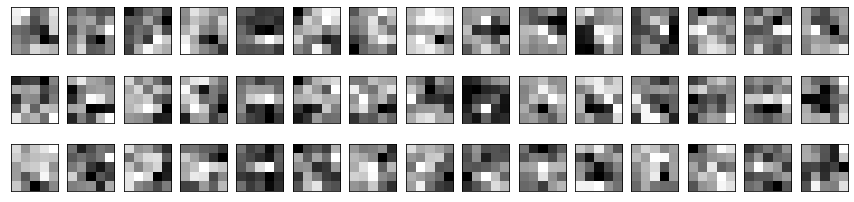

In [41]:
# Extract the filters out of the conv layers    
filters, biases = model_beta.layers[4].get_weights()

# Make it easier for us to plot
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)

# plot first few filters
n_filters, ix = 15, 1

fig, ax = plt.subplots(3,15,figsize=(15,15))

for i in range(n_filters):
    # get the filter
    f = filters[:, :, :, i]
    # plot each channel separately
    for j in range(3):
        ax[j,i].imshow(f[:, :, j],cmap="gray")
        ax[j,i].set_xticks([])
        ax[j,i].set_yticks([])
        
fig.subplots_adjust(bottom=0.02,top=0.2)

Some of these filters show an interesting image of how the model is trying to recognise the features in the images. Ofcourse the filters are small however there are some interesting shapes here.

Overall, this model could be improved upon by hyperparameter tuning to make it even more accurate. I believe it has the complexity needed to spot all of the features it just needs some tuning of number of filters and number of dense layers.

## 5.3 γ Model Gamma (CNN with two sets of Conv)

This is a model I got [from Kaggle](https://www.kaggle.com/code/shivank856/gtsrb-cnn-98-test-accuracy) that achieved very high accuracy (98%) with this dataset. The difference between this run and the one on kaggle is that I have augmented the images I am feeding in. See what difference it makes :-).

This neural network introduces the Batch Normalisation, Early stopping and Dropout layers which do the following:

#### Batch Normalisation
This layer calculates the mean and standard deviation to normalize the inputs in batches which speeds up the training. (as i understand it).


#### Dropout Layers
Drop out layers prevent overfitting by dropping some neurons through setting them to 0. It takes a parameter which is the percent of them that should be dropped. Here we are choosing 50%.
<img width=300 src="https://miro.medium.com/proxy/1*iWQzxhVlvadk6VAJjsgXgg.png"/>

#### Early Stopping
After some runs I thought this regularization method would help prevent overfitting as it stops training when a set variable is not changing with following epochs. You can set a patience which is the amount of epochs until it actually stops.

In [42]:
model_gamma = keras.models.Sequential([
    # Convolution Layer
    keras.layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu', input_shape=(IMG_HEIGHT,IMG_WIDTH,CHANNELS)),
    keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu'),
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    keras.layers.BatchNormalization(axis=-1),
    
    # Convolution Layer
    keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    keras.layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu'),
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    keras.layers.BatchNormalization(axis=-1),
    
    # Neural Network
    keras.layers.Flatten(),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(rate=0.5),
    
    keras.layers.Dense(43, activation='softmax')
])

learning_rate = 0.001
epochs = 15

optimizer = Adam(learning_rate=learning_rate, decay=learning_rate / (epochs * 0.5))
model_gamma.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
model_gamma.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 28, 28, 16)        448       
                                                                 
 conv2d_4 (Conv2D)           (None, 26, 26, 32)        4640      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 13, 13, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_5 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 conv2d_6 (Conv2D)           (None, 9, 9, 128)        

/usr/local/lib/python3.9/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [72]:
es = EarlyStopping(monitor='val_loss', mode='min', patience=5)

if not os.path.isfile("gamma_history.npy") or not os.path.isfile("model_gamma_aug.pickle"):
    gamma_history = model_gamma.fit(X_train_aug, y_train_aug, batch_size=32, epochs=epochs,validation_data=(X_val, y_val),callbacks=[es])
    gamma_history = gamma_history.history
    np.save('gamma_history.npy',gamma_history)
    with open('model_gamma_aug.pickle', 'wb') as f:
        pickle.dump(model_gamma, f)
else:
    gamma_history = np.load('gamma_history.npy',allow_pickle='TRUE').item()
    with open('model_gamma_aug.pickle', 'rb') as f:
        model_gamma = pickle.load(f)

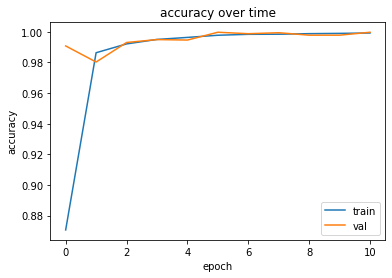

In [73]:
#alpha_history.history
# Loss
plt.plot(gamma_history['accuracy'])
plt.plot(gamma_history['val_accuracy'])
plt.title("accuracy over time")
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower right')
plt.show()

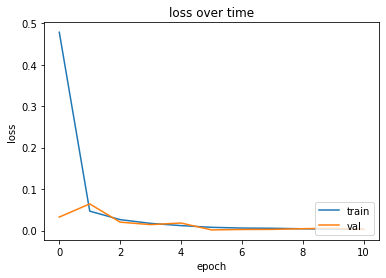

In [74]:
#gamma_history.history
plt.plot(gamma_history['loss'])
plt.plot(gamma_history['val_loss'])
plt.title("loss over time")
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower right')
plt.show()

In [75]:
model_gamma.evaluate(X_test,y_test)

246/246 [==============================] - 4s 15ms/step - loss: 0.0064 - accuracy: 0.9983


[0.006375104188919067, 0.9983422756195068]

In [47]:
probabilities_gamma = model_gamma.predict(X_test)
predictions_gamma = np.argmax(probabilities_gamma,axis=1)

In [48]:
# List of indexes that model got wrong
wrong_indices = [i for i,v in enumerate(predictions_gamma) if predictions_gamma[i]!=y_test[i]]
wrong_indices[:10]

[587, 951, 1261, 1372, 2561, 2992, 3310, 3334, 3624, 4100]

Model Predicted: Traffic signals
Confidence: 0.3083500266075134


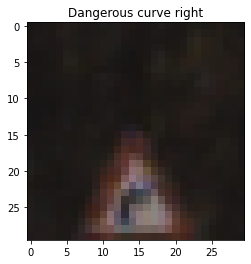

In [76]:
# Pick a number
n = 951

# Plot and check if prediction matches
plot_sign(X_test,y_test,n)
print(colour.BOLD+f"Model Predicted: {label_name[predictions_gamma[n]]}"+colour.END)
print(colour.BOLD+f"Confidence: {probabilities_gamma[n][predictions_gamma[n]]}"+colour.END)

Text(0.5, 114.0, 'Precited Labels')

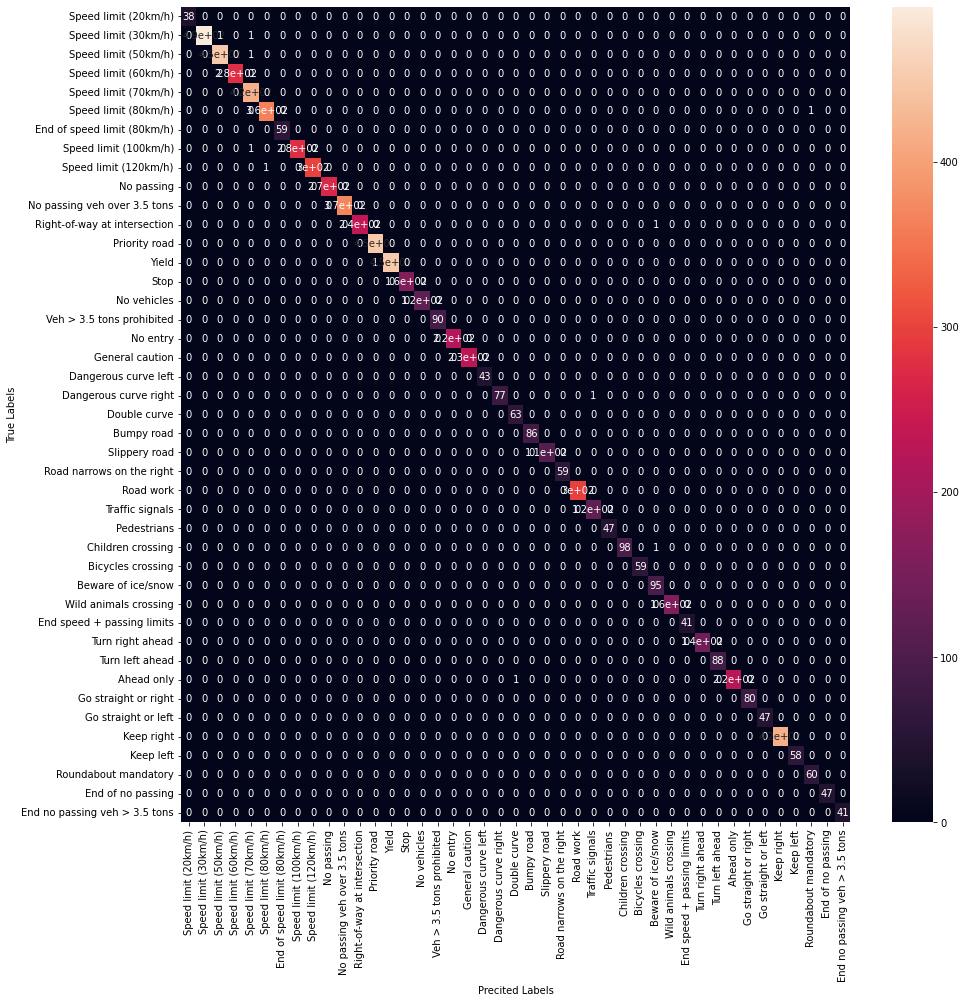

In [62]:
cm_mat_gamma = np.array(confusion_matrix(y_test,predictions_gamma))
cm_df_gamma = pd.DataFrame(cm_mat_gamma, index = [i for i in labels],
                  columns = [i for i in labels])
plt.figure(figsize = (15,15))
ax = sns.heatmap(cm_df_gamma, annot=True)
ax.set_ylabel("True Labels")
ax.set_xlabel("Precited Labels")

array([[3, 2, 2],
       [35, 21, 1],
       [28, 30, 1],
       [20, 26, 1],
       [13, 12, 1]], dtype=object)

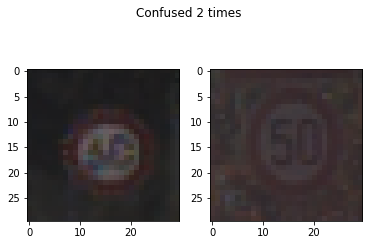

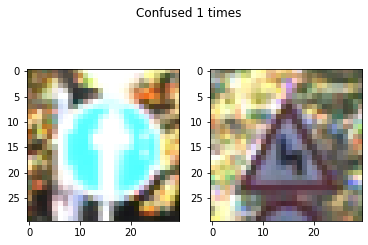

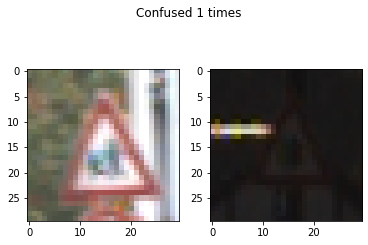

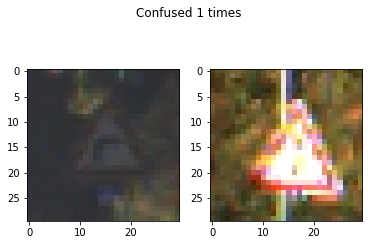

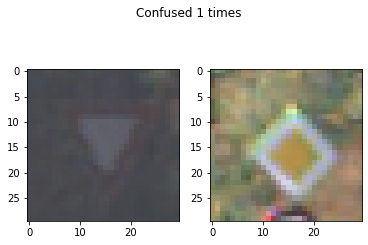

In [51]:
most_confused_signs(cm_mat_gamma,5)

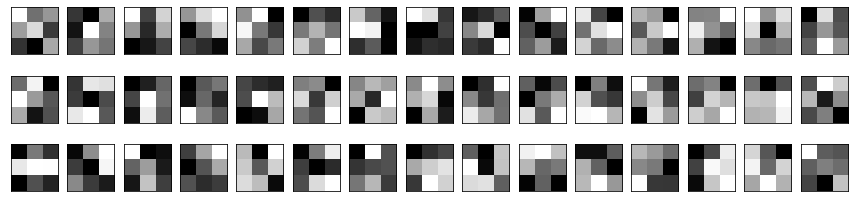

In [52]:
# Extract the filters out of the conv layers    
filters, biases = model_gamma.layers[1].get_weights()

# Make it easier for us to plot
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)

# plot first few filters
n_filters, ix = 15, 1

fig, ax = plt.subplots(3,15,figsize=(15,15))

for i in range(n_filters):
    # get the filter
    f = filters[:, :, :, i]
    # plot each channel separately
    for j in range(3):
        ax[j,i].imshow(f[:, :, j],cmap="gray")
        ax[j,i].set_xticks([])
        ax[j,i].set_yticks([])
        
fig.subplots_adjust(bottom=0.02,top=0.2)

These filters are not as usable as the previous, to get meaningful features I would need to make the filters bigger however I am limited to 30x30 images.

Last interesting metric to look at is precision and recall of each one of the classes. I will compute this for the gamma model only to save on time.

In [79]:
print(classification_report(y_test,predictions_gamma))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        38
           1       1.00      1.00      1.00       496
           2       0.99      1.00      1.00       450
           3       1.00      0.99      1.00       280
           4       0.99      1.00      1.00       418
           5       1.00      1.00      1.00       364
           6       1.00      1.00      1.00        59
           7       1.00      1.00      1.00       278
           8       1.00      1.00      1.00       301
           9       1.00      1.00      1.00       268
          10       1.00      1.00      1.00       370
          11       1.00      1.00      1.00       236
          12       1.00      1.00      1.00       450
          13       1.00      1.00      1.00       452
          14       1.00      1.00      1.00       162
          15       1.00      1.00      1.00       120
          16       1.00      1.00      1.00        90
          17       1.00    

All of these are so high that it rounds it up to 1, great... This sounds a little too good to be true as I dont imagine the model generalises very well to pictures of road signs in the wild. I do not have enough time to investigate this before handing in this task. :-(

In conclusion, I think really got carried away with this project as it still needs a lot of work with tweaking the models and adjusting the data augmentation. 

### If I had more time the things I would do is:
- Choose one model and stick with it (probably gamma)
- Perform hyperparameter optimisation (and cross-validation)
- Introduce another dataset of the same signs to see how it compares with the gamma model
- Experiment more with the Data augmentation (less samples to train with as 1600 out of 200 is a quite a lot)

After you run this notebook and models are trained. Make sure to try out the webcam implementation of each one of these models in your terminal.

    ## model_names = "alpha_aug", "beta_aug", "gamma_aug"

    $ python3 model_live.py --model <model_name>
   